In [1]:
import cv2
import numpy as np
import os 

from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from scipy import ndimage

# My custom library of photoelastic tools
import sys
#sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')
sys.path.append('/eno/jdfeathe/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff
from pepe.preprocess import cannyEdgeDetection, laplacianEdgeDetection, sobelEdgeDetection, applyFilter

from pepe.analysis import gSquared
from pepe.tracking import houghCircle, convCircle

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

from PIL import Image

#dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
dataFolder = '/eno/jdfeathe/DATA/SpaceJam/'

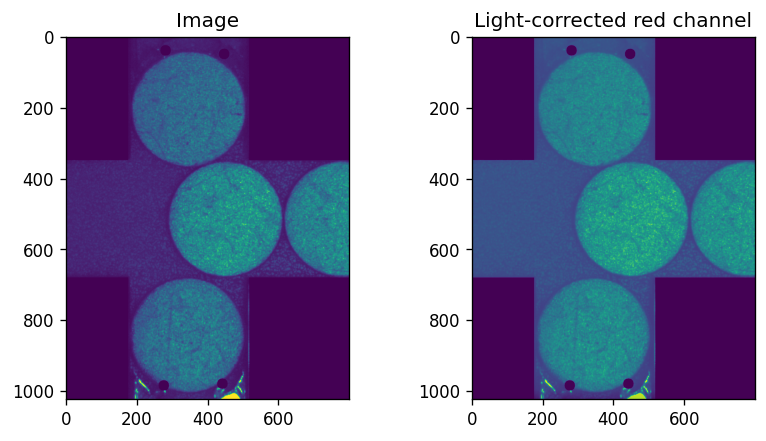

In [6]:
# Load in image, convert to gray scale, and Otsu's threshold
dataSet = '2022-03-16_Medium'

cropXBounds = [200, 1000]

image = checkImageType(dataFolder + dataSet + '/frame0001.bmp')[:,cropXBounds[0]:cropXBounds[1]]

maskArr = checkImageType(f'./Masks/{dataSet.split("_")[0]}_FullMask.bmp')[:,cropXBounds[0]:cropXBounds[1]]
verticalMask = checkImageType(f'./Masks/{dataSet.split("_")[0]}_VerticalMask.bmp')[:,cropXBounds[0]:cropXBounds[1],0]
horizontalMask = checkImageType(f'./Masks/{dataSet.split("_")[0]}_HorizontalMask.bmp')[:,cropXBounds[0]:cropXBounds[1],0]

correctionImage = checkImageType(dataFolder + f'calibration/{dataSet.split("_")[0]}_Calibration.bmp')[:,cropXBounds[0]:cropXBounds[1]]
g2CalibrationImage = checkImageType(dataFolder + f'calibration/{dataSet.split("_")[0]}_G2_Calibration.bmp')[:,cropXBounds[0]:cropXBounds[1]]

# Account for any light gradients using a calibration image
correction = lightCorrectionDiff(correctionImage, verticalMask, horizontalMask, rectify=True)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(image[:,:,0] * maskArr[:,:,0])
ax[0].set_title('Image')

ax[1].imshow((image[:,:,0] + correction) * maskArr[:,:,0])
ax[1].set_title('Light-corrected red channel')

plt.show()

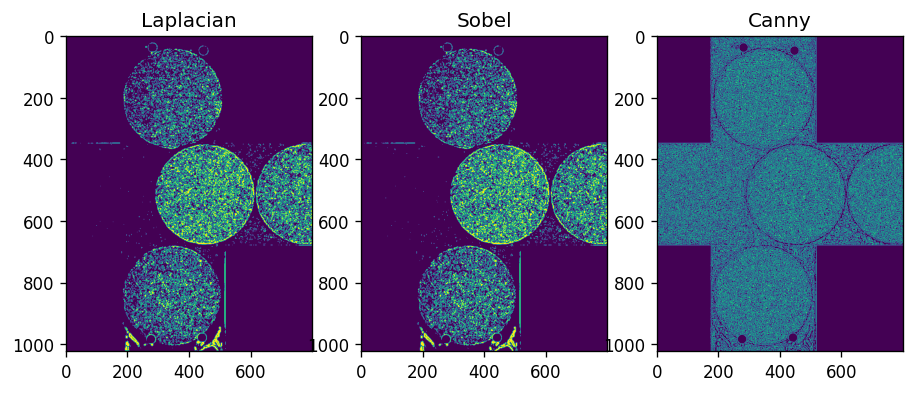

In [7]:
# Test some of the different edge detection methods
fig, ax = plt.subplots(1, 3, figsize=(9, 4))

horiSobelFilter = np.array([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]], dtype=np.float64)
vertiSobelFilter = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]], dtype=np.float64)

ax[0].imshow(laplacianEdgeDetection(image*maskArr))
ax[0].set_title('Laplacian')

ax[1].imshow(sobelEdgeDetection(image*maskArr))
ax[1].set_title('Sobel')

ax[2].imshow(cannyEdgeDetection(image*maskArr, threshold=.0001))
ax[2].set_title('Canny')

plt.show()

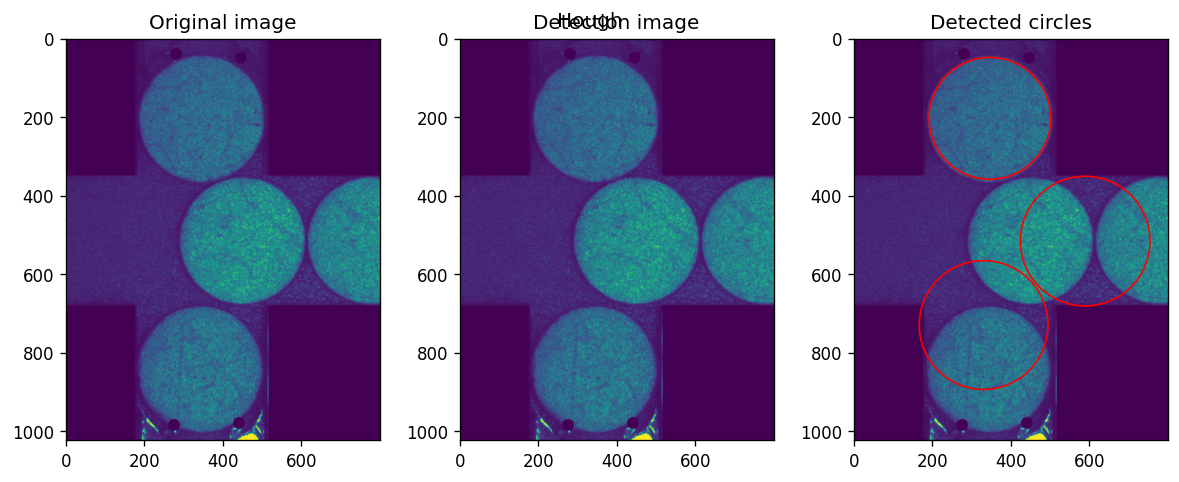

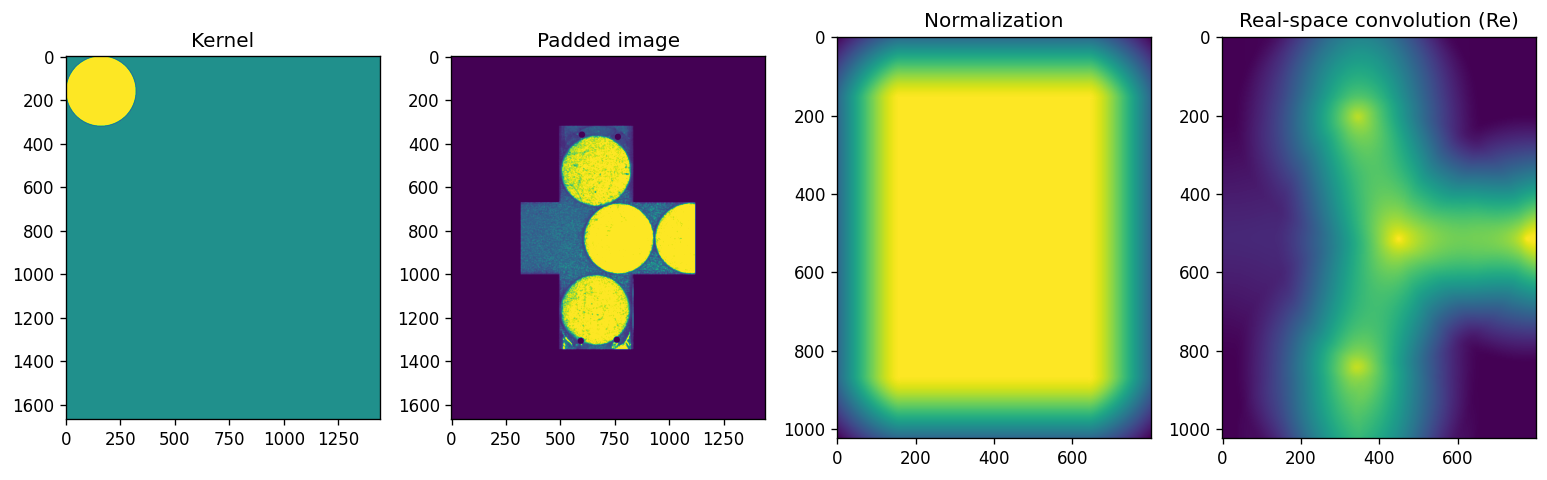

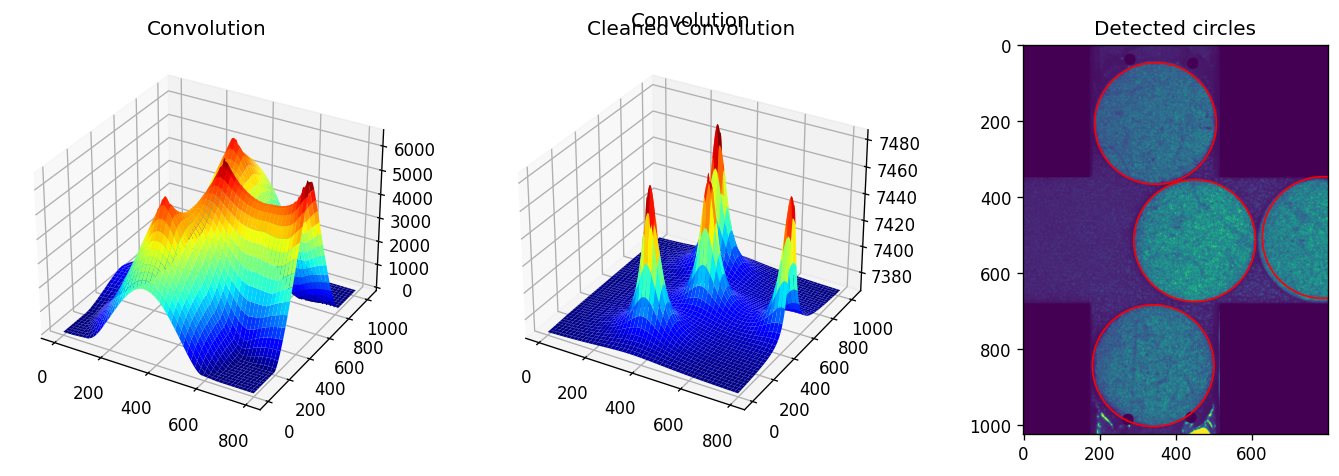

[[515.5 589.5]
 [202.5 346.5]
 [729.5 330.5]] [165.3 155.4 164.2]


In [14]:
radius = 160
centers, radii = houghCircle((image[:,:,0]) * maskArr[:,:,0], radius, edgeDetection=None,
                             accumulatorThreshold=20, cannyEdgeThreshold=60,
                             blurKernel=None, debug=True, radiusTolerance=7)
plt.gcf().suptitle('Hough')
plt.show()

particleCenters, particleRadii = convCircle(image[:,:,0] * maskArr[:,:,0], radius,
                                            debug=True, intensitySoftmax=2., intensitySoftmin=None, peakDownsample=5,
                                            offscreenParticles=True, radiusTolerance=None, negativeHalo=True)
plt.gcf().suptitle('Convolution')
plt.show()
print(centers, radii)

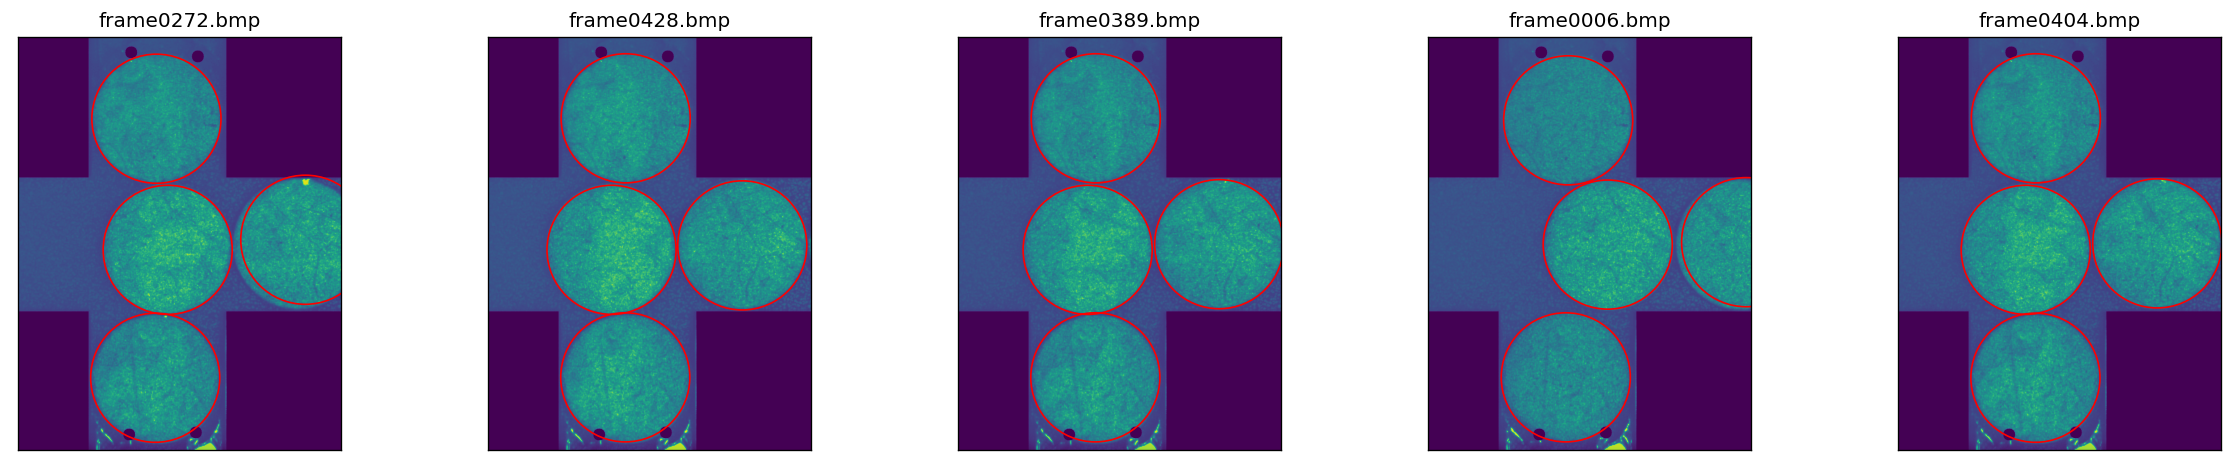

In [19]:
# Now let's test it on a whole bunch of images
testCases = 5
radius = 160

testImages = np.random.choice(os.listdir(dataFolder + dataSet), size=testCases)

fig, ax = plt.subplots(1, testCases, figsize=(4*testCases, 4))

for i in range(testCases):
    image = checkImageType(dataFolder + f'{dataSet}/{testImages[i]}')[:,cropXBounds[0]:cropXBounds[1]]
    
    centers, radii = convCircle(image[:,:,0] * maskArr[:,:,0], radius,
                                                debug=False, intensitySoftmax=2., peakDownsample=5,
                                                offscreenParticles=False, radiusTolerance=None, negativeHalo=True)
    
    ax[i].imshow((image[:,:,0] + correction) * maskArr[:,:,0])
    ax[i].set_title(testImages[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    for j in range(len(centers)):
        c = plt.Circle(centers[j][::-1], radii[j], color='red', fill=False, linewidth=1)
        ax[i].add_artist(c)
        
fig.tight_layout()
#plt.savefig('tracking_test.png')
plt.show()

In [114]:
problematicImages = ['0263', '0084', '0019', '0266', '0161', '0294', '0178', '0246', '0237']

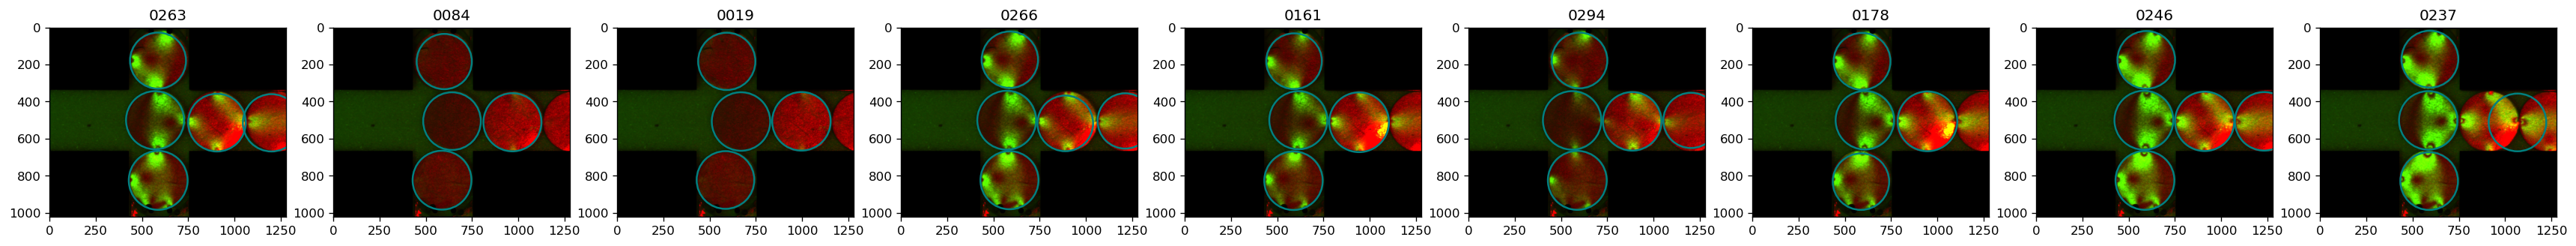

In [115]:
fig, ax = plt.subplots(1, len(problematicImages), figsize=(4*len(problematicImages), 4))

for i in range(len(problematicImages)):
    image = checkImageType(dataFolder + f'2022-02-02_Wide/frame{problematicImages[i]}.bmp')

    centers, radii = houghCircle((image[:,:,0] + correction) * maskArr[:,:,0], 155, edgeDetection=None,
                             accumulatorThreshold=20, cannyEdgeThreshold=60,
                             blurKernel=None, radiusTolerance=7)
    
    ax[i].imshow(image * maskArr)
    ax[i].set_title(problematicImages[i])
    for j in range(len(centers)):
        c = plt.Circle(centers[j][::-1], radii[j], color='teal', fill=False, linewidth=1.5)
        ax[i].add_artist(c)
        
plt.show()

In [20]:
from scipy.ndimage.filters import uniform_filter1d, correlate1d

def lowpass(image, sigma=1, truncate=4):
    """Remove noise by convolving with a Gaussian.
    Convolve with a Gaussian to remove short-wavelength noise.
    The lowpass implementation relies on scipy.ndimage.filters.gaussian_filter,
    and it is the fastest way known to the authors of performing a bandpass in
    Python.
    Parameters
    ----------
    image : ndarray
    sigma : number or tuple, optional
        Size of the gaussian kernel with which the image is convolved.
        Provide a tuple for different sizes per dimension. Default 1.
    truncate : number, optional
        Determines the truncation size of the convolution kernel. Default 4.
    Returns
    -------
    result : array
        the processed image, as float
    See Also
    --------
    bandpass
    """
    sigma = validate_tuple(sigma, image.ndim)
    result = np.array(image, dtype=float)
    for axis, _sigma in enumerate(sigma):
        if _sigma > 0:
            correlate1d(result, gaussian_kernel(_sigma, truncate), axis,
                        output=result, mode='constant', cval=0.0)
    return result

def validate_tuple(value, ndim):
    if not hasattr(value, '__iter__'):
        return (value,) * ndim
    if len(value) == ndim:
        return tuple(value)
    raise ValueError("List length should have same length as image dimensions.")


def gaussian_kernel(sigma, truncate=4.0):
    "1D discretized gaussian"
    lw = int(truncate * sigma + 0.5)
    x = np.arange(-lw, lw+1)
    result = np.exp(x**2/(-2*sigma**2))
    return result / np.sum(result)

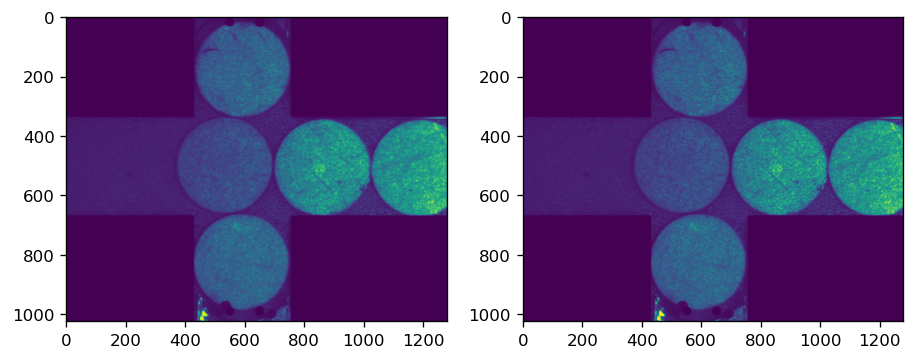

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

ax[0].imshow(lowpass(image[:,:,0]*maskArr[:,:,0]))
ax[1].imshow(image[:,:,0]*maskArr[:,:,0])

plt.show()

In [16]:
img = Image.fromarray(image*maskArr)
img.save('test.png')

ker = Image.fromarray(circularMask((240, 240), (120, 120), 120)*255)
ker.save('ker.png')